### Классификация токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Проект с BERT

##  Содержание проекта

<a href='#step1'>1.Подготовка</a>

<a href='#step2'>2.Обучение</a>

<a href='#step3'>3.Вывод</a>

# 1. Подготовка <a id='step1'></a>

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score
from tqdm import notebook
import torch
import transformers as ppb

import warnings
warnings.filterwarnings('ignore')

Загрузим и осмотрим данные

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на распределение целевого признака, построив гистограмму и подсчитав уникальные значения

Text(0.5, 1.0, 'распределение целевого признака')

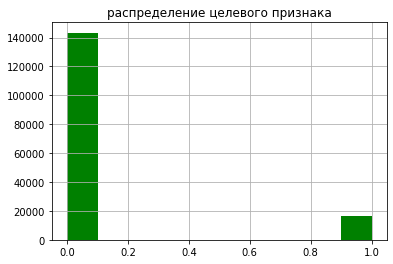

In [4]:
df['toxic'].hist(color = "g");
plt.title('распределение целевого признака')

In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Присутствует дисбаланс в целевом признаке. Количество токсичных комментариев значительно меньше. Необходимо это учеть при обучении моделей.

Прежде чем извлечь признаки из текста, упростим его.
Воспользуемся Лемматизацией — приведение слова к начальной форме (лемме).
Применим лемматизатор Wordnet из NLTK.

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Чтобы найти правильный POS-тег для каждого слова, сопоставим его с правильным входным символом, который принимает WordnetLemmatizer, и передадим его в качестве второго аргумента в lemmatize().
В nltk для этого есть метод nltk.pos_tag(). Он принимает список слов, а возвращает кортеж с тегом POS. Ключевым моментом здесь является сопоставление POS-тегов NLTK с форматом, принятым лемматизатором wordnet.

Воспользуемся готовыми и напишем функции для лемматизации текста:
get_wordnet_pos(word) - возвращает POS тэг для слова(к какой части речи относится слово)
clear_text(text) - приводит к нижнему регистру и очишает от символом, кроме букв английского алфавита(через re)
lemmatize(text) - проводит лемматизацию текста

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])      
    return lemm_text

In [10]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

Проверим, что функции работают корректно на тексте первой строке обучающей выборки

In [11]:
df.loc[0, 'text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
lemmatize(clear_text(df.loc[0, 'text']))

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

Проведем лемматизацию

In [13]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: lemmatize(clear_text(text)))

CPU times: user 35min 22s, sys: 2min 57s, total: 38min 19s
Wall time: 38min 36s


In [16]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


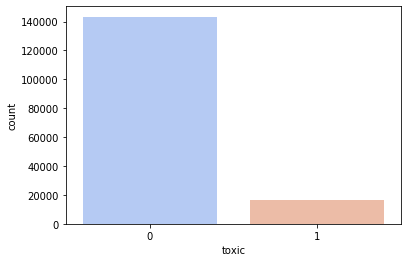

In [17]:
sns.countplot(x='toxic', data=df, palette='coolwarm');

Для того, чтобы сохранить результаты лемматизации и не запускать снова трудоемкий процесс, сохраним в csv и будем использовать его.

In [ ]:
df.to_csv('lemm_toxic_comments.csv', index=False)

In [ ]:
df = pd.read_csv('lemm_toxic_comments.csv')

Разделим датафрейм на 2 части

In [18]:
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=17)

Выведем размеры матриц и векторов:

In [19]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((119678,), (39893,), (119678,), (39893,))

Создадим корпуса слов для обучающей и тестовой выборок

In [20]:
train_corpus = train_features.values.astype('U')
test_corpus = test_features.values.astype('U')

Чтобы почистить мешок слов, найдём стоп-слова.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))

#### Вычислим TF-IDF для корпуса текстов

Рассчитать TF-IDF можно и в библиотеке sklearn. Класс TfidfVectorizer() в модуле sklearn.feature_extraction.text

In [23]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(train_corpus)
test_tf_idf = count_tf_idf.transform(test_corpus)

Выведем размеры получившихся матриц:

In [24]:
print("Размер обучающей матрицы:", train_tf_idf.shape), 
print("Размер тестовой матрицы:", test_tf_idf.shape)

Размер обучающей матрицы: (119678, 128432)
Размер тестовой матрицы: (39893, 128432)


Напишем функцию scoring(fitted_model) для определения метрики f1_score для тестовой выбороки

In [25]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(test_tf_idf)
    test_f1 = f1_score(test_target, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

### Вывод

В процессе загрузки и обработки данных обнаружены следующие факты

В данных присутствовал дисбаланс целевого признака
NLTK библиотека позволила преобразоваться тексты в векторный вид, пригодный для обучения моделей.
TF-IDF существенно увеличил количество признаков, равное количеству в мешке слов.

# 2. Обучение  <a id='step1'></a>

Обучим несколько моделей и оценим полученные результаты.
Модели для обучения:

* LogisticRegression
* XGBClassifier
* CatBoostClassifier
* LGBMClassifier

Для подбора гиперпараметров импортируем GridSearchCV, для кросс-валидации при подборе гиперпараметров ShuffleSplit:

In [26]:
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=17)

#### Обучим логистическую регресиию LogisticRegression как базовую модель

In [27]:
log_reg = LogisticRegression(random_state=17, class_weight='balanced')

In [28]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [29]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(train_tf_idf, train_target)

CPU times: user 8min 57s, sys: 8min 6s, total: 17min 3s
Wall time: 17min 6s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [30]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 11.1112}
best scores:  0.7575399592857313


In [31]:
log_reg_grid.best_estimator_

LogisticRegression(C=11.1112, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
%%time
scoring(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.761
CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 24.7 ms


#### Обучим модель градиентного бустинга XGBClassifier

In [33]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1)

In [34]:
xgb_clf_params = {'n_estimators': [100, 500]}

In [35]:
%%time
xgb_clf_grid = GridSearchCV(xgb_clf, xgb_clf_params, scoring='f1')
xgb_clf_grid.fit(train_tf_idf, train_target)

CPU times: user 54min, sys: 0 ns, total: 54min
Wall time: 54min 13s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=17, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None, param_grid={'n_estimators': [100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [36]:
print('best parameters: ', xgb_clf_grid.best_params_)
print('best scores: ', xgb_clf_grid.best_score_)

best parameters:  {'n_estimators': 500}
best scores:  0.7061738769236844


In [37]:
xgb_clf_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
%%time
scoring(xgb_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.709
CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 2.8 s


#### Обучим модель градиентного бустинга CatBoostClassifier

In [39]:
train_target

86305     0
86000     0
122621    0
150823    0
128349    0
         ..
25631     0
125680    0
42297     0
34959     1
64753     0
Name: toxic, Length: 119678, dtype: int64

In [40]:
scale_pos_weight = round((len(train_target[train_target == 0]) / 
                          len(train_target[train_target == 1])), 3)
scale_pos_weight

8.857

In [41]:
CatBoost_clf = CatBoostClassifier(random_state=17, iterations=500, scale_pos_weight=scale_pos_weight)

In [42]:
%%time
CatBoost_clf.fit(train_tf_idf, train_target)

Learning rate set to 0.120343
0:	learn: 0.6370528	total: 5.65s	remaining: 46m 57s
1:	learn: 0.6007665	total: 10.3s	remaining: 42m 32s
2:	learn: 0.5772803	total: 15s	remaining: 41m 32s
3:	learn: 0.5614775	total: 19.7s	remaining: 40m 47s
4:	learn: 0.5524966	total: 24.2s	remaining: 40m
5:	learn: 0.5386061	total: 28.7s	remaining: 39m 26s
6:	learn: 0.5299564	total: 33.3s	remaining: 39m 8s
7:	learn: 0.5222804	total: 37.9s	remaining: 38m 53s
8:	learn: 0.5146054	total: 42.5s	remaining: 38m 40s
9:	learn: 0.5048728	total: 46.8s	remaining: 38m 15s
10:	learn: 0.4986368	total: 51.4s	remaining: 38m 6s
11:	learn: 0.4930663	total: 56s	remaining: 37m 59s
12:	learn: 0.4885478	total: 1m	remaining: 37m 51s
13:	learn: 0.4829496	total: 1m 5s	remaining: 37m 41s
14:	learn: 0.4785651	total: 1m 9s	remaining: 37m 28s
15:	learn: 0.4743093	total: 1m 14s	remaining: 37m 19s
16:	learn: 0.4699834	total: 1m 18s	remaining: 37m 11s
17:	learn: 0.4648785	total: 1m 22s	remaining: 36m 58s
18:	learn: 0.4606197	total: 1m 27s	r

In [43]:
%%time
scoring(CatBoost_clf)

F1 на тестовой выборке: 0.750
CPU times: user 1.46 s, sys: 355 ms, total: 1.82 s
Wall time: 1.83 s


#### Обучим модель градиентного бустинга LGBMClassifier

In [44]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17, class_weight='balanced')

In [45]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [ ]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(train_tf_idf, train_target)

In [ ]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

In [ ]:
lgbm_clf_grid.best_estimator_

In [ ]:
%%time
scoring(lgbm_clf_grid.best_estimator_)

In [ ]:
*

#### BERT

DistilBERT представляет собой уменьшенную версию BERT'а. Она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.

Загрузим предобученную модель DistilBERT и токенизатор.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
df

In [ ]:
%%time
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=df['text'].shape[0])))

Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512. Посчитаем длины текстов с токенами

In [ ]:
len_sentences = [len(i) for i in tokenized]

In [ ]:
len_sentences = pd.Series(len_sentences)
len_sentences.describe()

Видем что есть аномально длинные. Ограничим тексты максимальной длиной токенов 75% квантилем.

In [ ]:
indexes = []
for i in notebook.tqdm(range(len(tokenized))):
    if len(tokenized[i]) <= len_sentences.quantile(.75):
        indexes.append(i)

In [ ]:
len(indexes)

In [ ]:
filtered_df = df.query('index in @indexes')

In [ ]:
filtered_df.shape

Разделим датафрейм на 2 части

In [ ]:
filtered_df_train, filtered_df_test = train_test_split(filtered_df, random_state=17, test_size=5000)

In [ ]:
filtered_df_train.shape, filtered_df_test.shape

Для того, чтобы сбалансировать метки целевого признака в обучающей выборке, воспользуемся техникой downsampling

#### Уменьшение выборки downsampling

In [ ]:
coef  = round((len(filtered_df_train[filtered_df_train['toxic'] == 1]) / 
               len(filtered_df_train[filtered_df_train['toxic'] == 0])), 3)
coef

Напишем функцию downsample(features, target, fraction) для формирования сблалансированной выборки

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=17)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=17)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=17)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(filtered_df_train['text'], filtered_df_train['toxic'], coef)

Выведем размеры получившихся выборок и распределение целевого признака в обучающей выборке:

In [ ]:
features_downsampled.shape, target_downsampled.shape

In [ ]:
sns.set()
sns.countplot(target_downsampled, palette='coolwarm');

Объеденим снова в один ДатаФрейм обучающую выборку

In [ ]:
features_downsampled = pd.DataFrame(features_downsampled).reset_index(drop=True)
target_downsampled = pd.DataFrame(target_downsampled).reset_index(drop=True)
filtered_df_train = features_downsampled.join(target_downsampled)

In [ ]:
filtered_df_train.shape, filtered_df_test.shape

Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим (100). Обучающую выборку сделаем кратной размеру батча.

In [ ]:
filtered_df_train = filtered_df_train[:25900]

Выполним токенезацию новых текстов

In [ ]:
%%time
tokenized_train = filtered_df_train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_train['text'].shape[0])))

In [ ]:
%%time
tokenized_test = filtered_df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_test['text'].shape[0])))

Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. Только при таком условии будет работать модель BERT.

In [ ]:
def padding(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    return padded

padded_train = padding(tokenized_train)
padded_test = padding(tokenized_test)

In [ ]:
np.array(padded_train).shape, np.array(padded_test).shape

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание». Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения

In [ ]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_train.shape, attention_mask_test.shape

Сделав цикл по батчам, отобразим прогресс функцией notebook()
Преобразуем данные в формат тензоров. Тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.
Чтобы получить эмбеддинги для батча, передадим модели данные и маску
Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.
Из полученного тензора извлечём нужные элементы batch_embeddings[0][:,0,:].numpy() и добавим в список всех эмбеддингов

In [ ]:
def embedings(padded, attention_mask):
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    features = np.concatenate(embeddings)
    return features

In [ ]:
features_train = embedings(padded_train, attention_mask_train)

In [ ]:
features_test = embedings(padded_test, attention_mask_test)

Целевые признаки

In [ ]:
labels_train = filtered_df_train['toxic']
labels_test = filtered_df_test['toxic']

In [ ]:
def scoring_BERT(fitted_model):
    test_pred = fitted_model.predict(features_test)
    test_f1 = f1_score(labels_test, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

### Обучим Логистическую регрессию LogisticRegression

In [ ]:
log_reg = LogisticRegression(random_state=17)

In [ ]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [ ]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(features_train, labels_train)

In [ ]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

In [ ]:
log_reg_grid.best_estimator_

In [ ]:
%%time
scoring_BERT(log_reg_grid.best_estimator_)

### Обучим модель градиентного бустинга XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=500)

In [ ]:
%%time
xgb_clf.fit(features_train, labels_train)

In [ ]:
scoring_BERT(xgb_clf)

### Обучим модель градиентного бустинга CatBoostClassifier

In [ ]:
CatBoost_clf = CatBoostClassifier(random_state=17, iterations=500)

In [ ]:
%%time
CatBoost_clf.fit(features_train, labels_train)

In [ ]:
scoring_BERT(CatBoost_clf)

### Обучим модель градиентного бустинга LGBMClassifier

In [ ]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17)

In [ ]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [ ]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(features_train, labels_train)

In [ ]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

In [ ]:
lgbm_clf_grid.best_estimator_

In [ ]:
%%time
scoring_BERT(lgbm_clf_grid.best_estimator_)

### Проверка модели на вменяемость

Для того, чтобы получить «случайные» результаты, воспользуемся DummyClassifier. Полученные им результаты абсолютно случайные.

In [ ]:
dummy_clf = DummyClassifier()

In [ ]:
scores = cross_val_score(dummy_clf, features_train, labels_train, scoring='f1')
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
dummy_clf.fit(features_train, labels_train)

In [ ]:
scoring_BERT(dummy_clf)

Видим что в среднем модель предсказывает 50/50. Что гораздо хуже рассмотренных выше моделей.

### Вывод

В процессе обучения моделей обнаружили по TF-IDF:

Почти все модели показали значение f1 в районе 0.76.
Лучшей по метрики f1 является Логистическая XGBClassifier
Лучшей по времени обучения Логистическая Регрессия

В процессе обучения моделей по BERT:

Почти все модели показали значение f1 в районе 0.67
Лучшей также является Логистическая Регрессия c результатом 0.69

# 3. Выводы  <a id='step1'></a>

Проанализируем все модели на качество предсказания, скорость обучения

Сведем все данные в таблицу

In [14]:
data = {'Модель':['LogisticRegression', 'XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier'], 
        'Скорость обучения':['Очень высокая', 'Высокая', 'Высокая', 'Очень высокая'],
        'Качество предсказания по TF-IDF': [0.761, 0.775, 0.75, 0.76],
        'Качество предсказания по BERT': [ 0.69, 0.676, 0.675, 0.674]}

In [15]:
df1 = pd.DataFrame(data)
df1

,Модель,Скорость обучения,Качество предсказания по TF-IDF,Качество предсказания по BERT
0,LogisticRegression,Очень высокая,0.761,0.690
1,XGBClassifier,Высокая,0.775,0.676
2,CatBoostClassifier,Высокая,0.750,0.675
3,LGBMClassifier,Очень высокая,0.760,0.674


### Вывод

По результатам исследований моделей для поставленной задачи наиболее оптимальными являются:

**LogisticRegression**

LogisticRegression - базовая модель, показывает хорошие показатели метрик и скорости обучения и предсказания, очень проста в настройке и не требует особой настройки гиперпараметров по сетке. Очень хорошо работает с предобработанными данными (после TF-IDF).
В целом все модели дают хорошие показатели метрики, но по скорости обучения отличаются.

Представление текста в векторную форму через BERT проще, поскольку не требует предварительной лемматизации, но есть свои особенности в настройки модели.

Для данной задачи лучшая для заказчика в плане качества предсказания, скорости предсказания, время обучения - LogisticRegression.
Она лучше всего работает с предобработанными данными и имеет самую высокую скорость обучения, как все линейные модели.